In [1]:
from google.cloud import bigquery
import os
from dotenv import load_dotenv
import pandas as pd
import logging
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import Birch


/Users/ecesuolgun/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
#Logging configuration
logging.basicConfig(
    level=logging.INFO, 
    format="%(asctime)s - %(levelname)s - %(message)s", 
)

In [3]:
load_dotenv()
CREDENTIALS_PATH = os.getenv('GOOGLE_APPLICATION_CREDENTIALS')
if os.path.exists('clustered_events.feather'):
    logging.info("Local file found, loading...")
    df = pd.read_feather('clustered_events.feather')
else:
    logging.info("Local file not found, fetching from BigQuery...")
    query = """
    SELECT *
    FROM `apps-interview-project.analytics_v2.clustered_events`
    """
    client = bigquery.Client.from_service_account_json(CREDENTIALS_PATH)
    df = client.query(query).to_dataframe()
    df.to_feather('clustered_events.feather')

2025-04-30 22:37:20,283 - INFO - Local file found, loading...


In [4]:
def calculate_revenue_windows(df):
    #Windows = [0,3,7]
    df['installed_datetime'] = df['installed_datetime'].dt.tz_localize(None)
    df['install_date'] = df['installed_datetime'].dt.normalize()
    df['days_since_install'] = (df['event_date'] - df['install_date']).dt.days

    revenue_df = df[df['ad_revenue'].notnull() & (df['ad_revenue'] > 0)].copy()

    d0 = revenue_df[revenue_df['days_since_install'] == 0].groupby('user_id')['ad_revenue'].sum().rename('rev_d0')

    d3 = revenue_df[revenue_df['days_since_install'] <= 3].groupby('user_id')['ad_revenue'].sum().rename('rev_d3')

    d7 = revenue_df[revenue_df['days_since_install'] <= 7].groupby('user_id')['ad_revenue'].sum().rename('rev_d7')

    user_revenue = pd.DataFrame({'user_id': df['user_id'].unique()})
    user_revenue = user_revenue.merge(d0, on='user_id', how='left')
    user_revenue = user_revenue.merge(d3, on='user_id', how='left')
    user_revenue = user_revenue.merge(d7, on='user_id', how='left')
    user_revenue.fillna(0, inplace=True)

    return user_revenue


In [5]:
def preprocess_data(raw_df):
    raw_df['event_datetime'] = pd.to_datetime(raw_df['event_timestamp'], unit='us') 
    raw_df['install_date'] = pd.to_datetime(raw_df['installed_datetime'], unit='us') 
    raw_df['event_date'] = pd.to_datetime(raw_df['event_date'])

    
    check_ads_df = raw_df[((raw_df['ad_revenue'].isnull()) & (raw_df['ad_type'].notnull())) | 
                  ((raw_df['ad_type'].isnull()) & (raw_df['ad_revenue'].notnull()))]

    if not check_ads_df.empty:
        logging.info("Muhtemelen db'ye veriler kaydedilirken bir hata yapıldı. Bunlar droplanacak.")
        raw_df = raw_df[~raw_df.index.isin(check_ads_df.index)]
    
    df = raw_df.drop(columns=['event_timestamp', 'exp_group'], axis = 1)
    df = df.sort_values('event_datetime')
    
    user_revenue = calculate_revenue_windows(df)
    

    return df, user_revenue

In [12]:
def save_eda_plots(output_dir, col, value_counts, title, xlabel, ylabel, color):
    fig, ax = plt.subplots(figsize=(8, 5))

    value_counts.plot(kind='bar', color=color, ax=ax)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.tick_params(axis='x', rotation=45)

    # Bar etiketleri
    for i, v in enumerate(value_counts):
        ax.text(i, v + 0.5, str(v), ha='center')

    filename = f"{output_dir}/{col}.png"
    fig.tight_layout()
    fig.savefig(filename)
    logging.info(f"Plot saved to {filename}\n")
    plt.show()  # Grafik ekranda da gösterilsin


In [19]:
def label_cluster(row):
    if row['birch_cluster'] == 0:
        return 'No or Very Low Revenue'
    elif row['birch_cluster'] == 1:
        return 'Low Revenue'
    elif row['birch_cluster'] == 3:
        return 'Medium Revenue'
    else:
        return 'High Revenue'


In [7]:
df, user_revenue = preprocess_data(df)
df.head()

,event_date,installed_datetime,platform,country,user_id,event_name,is_online,ad_revenue,ad_type,level_name,event_datetime,install_date,days_since_install
2203388,2024-07-01,2024-06-30 23:55:00.612,android,us,5820934861762761160,AdImpressionRevenue,<NA>,0.001052,banner,<NA>,2024-07-01 00:00:00.062,2024-06-30,1.0
4496877,2024-07-01,2024-06-06 23:06:24.794,android,us,2505569074672817941,AdImpressionRevenue,<NA>,0.000892,banner,<NA>,2024-07-01 00:00:00.096,2024-06-06,25.0
9107608,2024-07-01,2024-06-30 23:18:27.293,android,ca,-2986919920102759774,AdImpressionRevenue,<NA>,0.001310,banner,<NA>,2024-07-01 00:00:00.813,2024-06-30,1.0
3126338,2024-07-01,2024-06-30 18:47:22.927,android,us,8252864593252586328,AdImpressionRevenue,<NA>,0.003454,banner,<NA>,2024-07-01 00:00:01.087,2024-06-30,1.0
5450919,2024-07-01,2024-06-29 22:44:40.927,android,us,3298063069325728389,level_start,<NA>,NaN,None,37,2024-07-01 00:00:01.274,2024-06-29,2.0


#  EDA:

In [7]:
# 1. Total number of unique users
unique_users = df['user_id'].nunique()
logging.info(f"Total number of unique users: {unique_users}")

# 2. Number of unique users by country
users_by_country = df.groupby('country')['user_id'].nunique().sort_values(ascending=False)
logging.info("Number of unique users by country:")
logging.info(f"\n{users_by_country}")

# 3. Number of unique users by platform
users_by_platform = df.groupby('platform')['user_id'].nunique()
logging.info("Number of unique users by platform:")
logging.info(f"\n{users_by_platform}")

# 4. Combined summary by platform and country
summary_df = df.groupby(['platform', 'country'])['user_id'].nunique().reset_index()
summary_df.columns = ['Platform', 'Country', 'Unique_User_Count']
logging.info("Unique user count by platform and country:")
logging.info(f"\n{summary_df}")

2025-04-30 21:51:10,110 - INFO - Total number of unique users: 176626
2025-04-30 21:51:10,644 - INFO - Number of unique users by country:
2025-04-30 21:51:10,645 - INFO - 
country
us    55746
tr    40217
gb    23619
es    15514
de    10580
      ...  
pg        1
ss        0
bt        0
er        0
to        0
Name: user_id, Length: 180, dtype: int64
2025-04-30 21:51:11,149 - INFO - Number of unique users by platform:
2025-04-30 21:51:11,150 - INFO - 
platform
android    120421
ios         56205
Name: user_id, dtype: int64
2025-04-30 21:51:12,106 - INFO - Unique user count by platform and country:
2025-04-30 21:51:12,107 - INFO - 
    Platform Country  Unique_User_Count
0    android      ad                  3
1    android      ae                166
2    android      af                 11
3    android      al                 49
4    android      am                  4
..       ...     ...                ...
316      ios      ve                 28
317      ios      ye                  4
3

In [8]:
ad_type_counts = df['ad_type'].value_counts(dropna=False)
logging.info("Event count by ad type (including NaNs):")
logging.info(f"\n{ad_type_counts}")

level_counts = df['level_name'].value_counts(dropna=False).sort_index()
logging.info("Event count by level name (including NaNs):")
logging.info(f"\n{level_counts}")

event_name_counts = df['event_name'].value_counts()
logging.info("Event count by event name:")
logging.info(f"\n{event_name_counts}")


2025-04-30 21:51:12,226 - INFO - Event count by ad type (including NaNs):
2025-04-30 21:51:12,227 - INFO - 
ad_type
banner          9619046
None            2488172
interstitial    1211812
rewarded         178117
Name: count, dtype: int64
2025-04-30 21:51:12,265 - INFO - Event count by level name (including NaNs):
2025-04-30 21:51:12,266 - INFO - 
level_name
0               4
1          104084
2           96900
3           87987
4           83254
           ...   
16017           2
16018           1
16019           1
16020           1
<NA>     11693058
Name: count, Length: 1999, dtype: Int64
2025-04-30 21:51:12,513 - INFO - Event count by event name:
2025-04-30 21:51:12,514 - INFO - 
event_name
AdImpressionRevenue    11008975
level_start             1804089
GameStart                585096
InitialGameStart          98987
Name: count, dtype: int64


2025-04-30 21:51:12,598 - INFO - Event Name Distribution:
event_name
AdImpressionRevenue    11008975
level_start             1804089
GameStart                585096
InitialGameStart          98987
Name: count, dtype: int64

2025-04-30 21:51:12,684 - INFO - Plot saved to outputs/eda_plots/event_name.png



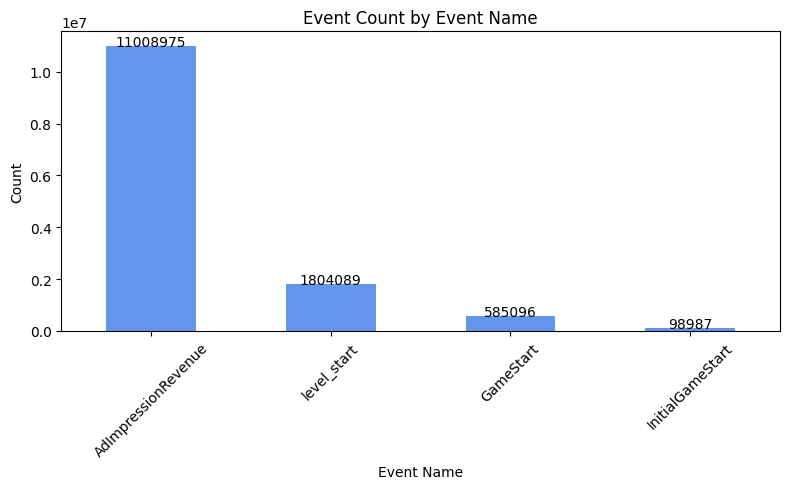

2025-04-30 21:51:12,846 - INFO - Ad Type Distribution:
ad_type
banner          9619046
None            2488172
interstitial    1211812
rewarded         178117
Name: count, dtype: int64

2025-04-30 21:51:12,945 - INFO - Plot saved to outputs/eda_plots/ad_type.png



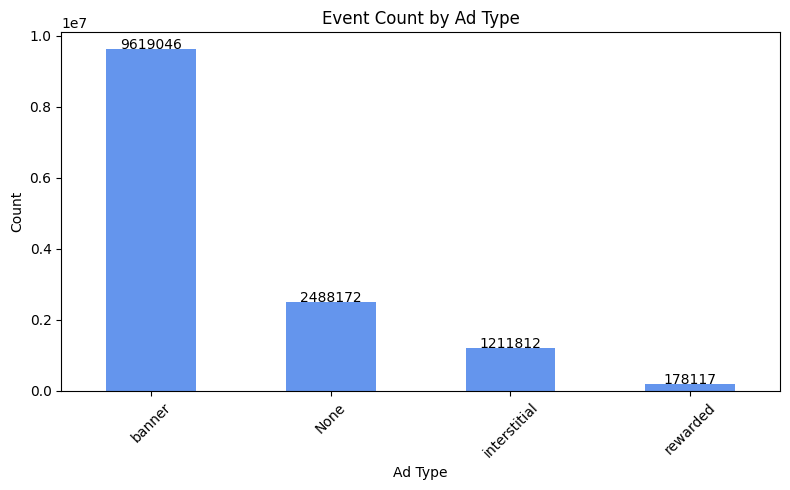

In [ ]:
columns_to_plot_categorical = ['event_name', 'ad_type']

for col in columns_to_plot_categorical:
    value_counts = df[col].value_counts(dropna=False)

    logging.info(f"{col.replace('_', ' ').title()} Distribution:\n{value_counts}\n")

    save_eda_plots(
        output_dir="outputs/eda_plots",
        col=f"{col}",
        value_counts=value_counts,
        title=f"Event Count by {col.replace('_', ' ').title()}",
        xlabel=col.replace('_', ' ').title(),
        ylabel="Count",
        color="cornflowerblue"
    )

2025-04-30 21:51:13,506 - INFO - Unique Users by Platform:
platform
android    120421
ios         56205
Name: user_id, dtype: int64

2025-04-30 21:51:13,564 - INFO - Plot saved to outputs/eda_plots/platform.png



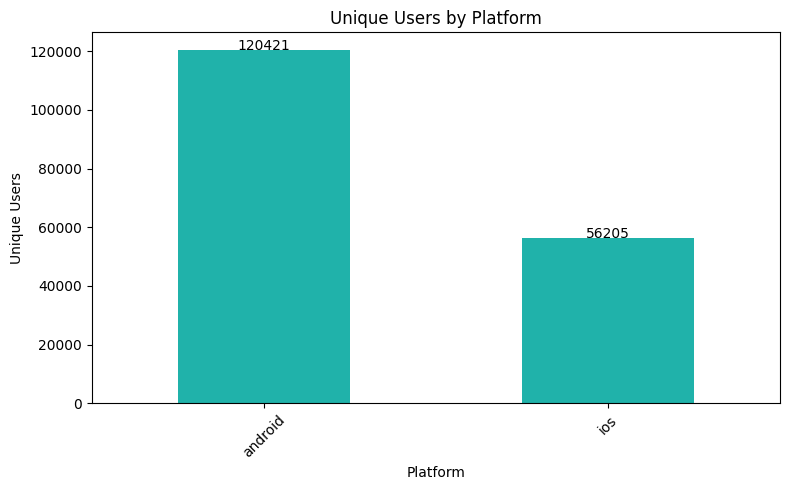

2025-04-30 21:51:14,139 - INFO - Unique Users by Country:
country
us    55746
tr    40217
gb    23619
es    15514
de    10580
fr    10269
ca     4698
mx     2233
au     1362
ir     1353
in      917
br      898
ae      715
ph      596
dk      585
id      555
be      531
ch      405
co      385
nl      365
Name: user_id, dtype: int64

2025-04-30 21:51:14,226 - INFO - Plot saved to outputs/eda_plots/country.png



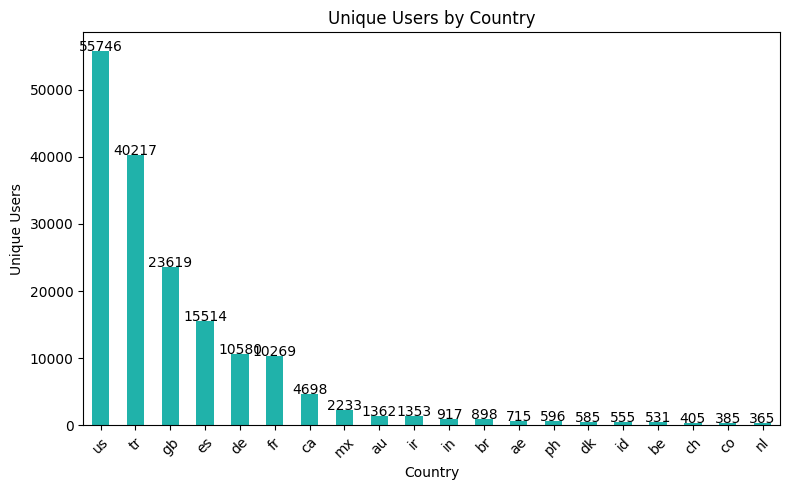

In [ ]:
nunique_columns = ['platform', 'country']

for col in nunique_columns:
    if col == 'country':
        value_counts = df.groupby(col)['user_id'].nunique().sort_values(ascending=False).head(20)
    else:
        value_counts = df.groupby(col)['user_id'].nunique().sort_values(ascending=False)
    
    logging.info(f"Unique Users by {col.title()}:\n{value_counts}\n")

    save_eda_plots(
        output_dir="outputs/eda_plots",
        col=f"{col}",
        value_counts=value_counts,
        title=f"Unique Users by {col.title()}",
        xlabel=col.title(),
        ylabel="Unique Users",
        color="lightseagreen"
    )

In [11]:
df_including_null_revenue_user_ids = df[df['ad_revenue'].isnull()].user_id.values

null_incl_rev_users_df = df[df['user_id'].isin(df_including_null_revenue_user_ids)].groupby('user_id')[['ad_revenue']].sum().reset_index().sort_values('ad_revenue', ascending=False)
null_incl_rev_users_df

,user_id,ad_revenue
60238,-2949850440414794901,114.471248
119404,3199024696807063262,91.159944
142740,5672432894938092291,77.374459
40559,-5025618815020944609,55.000000
94699,639556492733861874,51.316020
...,...,...
120713,3339759615173925541,0.000000
120716,3340032814930504323,0.000000
59029,-3075506499106683389,0.000000
157478,7218807043163925100,0.000000


In [12]:
all_null_ads_revenue_user_ids = null_incl_rev_users_df[null_incl_rev_users_df['ad_revenue'] == 0].reset_index().user_id.values

#Users we never gain money from country and platform based review:
no_money_gain_df_by_platform = df[df['user_id'].isin(all_null_ads_revenue_user_ids)].groupby('platform')['platform'].count()
no_money_gain_df_by_platform

platform
android    150766
ios         13413
Name: platform, dtype: int64

In [13]:
no_money_gain_df_by_country = df[df['user_id'].isin(all_null_ads_revenue_user_ids)]['country'].value_counts()
no_money_gain_df_by_country

country
us    37227
tr    23252
ir    17026
gb    13346
de    10729
      ...  
mc        2
dj        2
yt        1
fm        1
nc        1
Name: count, Length: 151, dtype: int64

Although the majority of ad revenue is driven by Turkish users, the largest group of users that generate no ad revenue comes from the US. 

This discrepancy indicates a potential monetization gap, suggesting either behavioral differences or inefficiencies in ad delivery for this market. 

A targeted investigation into ad viewability and user journey in the US segment is recommended.

<Axes: >

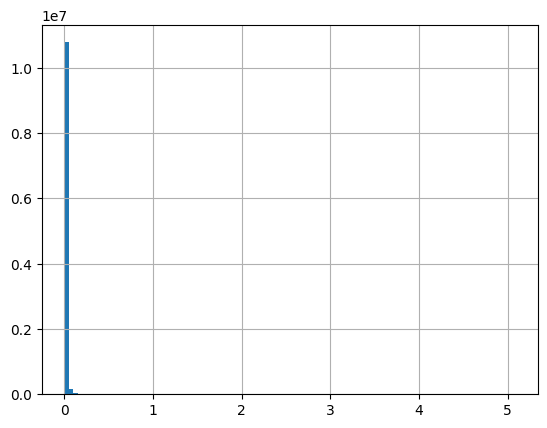

In [14]:
df['ad_revenue'].hist(bins=100)

Right-skewed data is observed, meaning that most values are close to zero, with a few extreme outliers on the higher end.

# Customer Segmentation

In [8]:
epsilon = 1e-6
user_revenue['rev_d7_log'] = np.log(user_revenue['rev_d7'] + epsilon)
birch = Birch(n_clusters=4)
user_revenue['birch_cluster'] = birch.fit_predict(user_revenue[['rev_d7_log']])
user_revenue.head()

,user_id,rev_d0,rev_d3,rev_d7,rev_d7_log,birch_cluster
0,5820934861762761160,0.0,0.737323,0.737323,-0.304728,3
1,2505569074672817941,0.0,0.000000,0.000000,-13.815511,0
2,-2986919920102759774,0.0,0.024206,0.024206,-3.721114,1
3,8252864593252586328,0.0,1.749061,2.512805,0.921400,2
4,3298063069325728389,0.0,0.220178,0.415320,-0.878704,3


In [9]:
user_revenue.groupby('birch_cluster')['rev_d7'].agg(['count', 'mean', 'median', 'min', 'max']).sort_values('min')

,count,mean,median,min,max
birch_cluster,,,,,
0,80715,9.725167e-07,0.000000,0.000000,0.000318
1,22048,1.357920e-02,0.012991,0.000319,0.029521
3,65910,2.309322e-01,0.143445,0.029524,0.944515
2,7954,2.109535e+00,1.461690,0.944658,109.539118


In [20]:
user_revenue['birch_cluster_label'] = user_revenue.apply(label_cluster, axis=1)
user_revenue.head()

,user_id,rev_d0,rev_d3,rev_d7,rev_d7_log,birch_cluster,birch_cluster_label
0,5820934861762761160,0.0,0.737323,0.737323,-0.304728,3,Medium Revenue
1,2505569074672817941,0.0,0.000000,0.000000,-13.815511,0,No or Very Low Revenue
2,-2986919920102759774,0.0,0.024206,0.024206,-3.721114,1,Low Revenue
3,8252864593252586328,0.0,1.749061,2.512805,0.921400,2,High Revenue
4,3298063069325728389,0.0,0.220178,0.415320,-0.878704,3,Medium Revenue


In [ ]:
user_revenue.to_csv('outputs/looker_studio_data/user_revenue_birch_segmented.csv', index=False)